In [1]:
#
import numpy as np
import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'

#survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'

Nranfiles = 3
patch = None #[174., 186., -3., 2.]
reg = 'desi' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr8'
#version = '2.0'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
dec_resol_ns = 32.375

# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

## catalogue

cat = merge_NS(sweep_north='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-north.npy', 
               extra_north='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-north_n256.npy', 
               sweep_south='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-south.npy',
               extra_south='/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-south_n256.npy',
               resolve_DEC=dec_resol_ns)

In [3]:

sweep_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-north.npy'
sweep_s_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets-south.npy'

extra_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-north_n256.npy'
extra_s_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/extra-south_n256.npy'

%time sweep_n = np.load(sweep_n_file)
%time sweep_s = np.load(sweep_s_file)

%time extra_n = np.load(extra_n_file)
%time extra_s = np.load(extra_s_file)

#resolve for north/south and select only BGS targets
bgs_n = ((sweep_n['BGSBITS'] & 2**(20)) != 0)
bgs_s = ((sweep_s['BGSBITS'] & 2**(20)) != 0)
keep_n = (sweep_n['DEC'] > dec_resol_ns) & (extra_n['b'] > 0) & (bgs_n)
keep_s = ((sweep_s['DEC'] < dec_resol_ns) & (extra_s['b'] > 0) & (bgs_s)) | ((extra_s['b'] < 0) & (bgs_s))

sweep_n = sweep_n[keep_n]
sweep_s = sweep_s[keep_s]

extra_n = extra_n[keep_n]
extra_s = extra_s[keep_s]

%time cat = np.concatenate((sweep_n, sweep_s))
%time extra = np.concatenate((extra_n, extra_s))


CPU times: user 0 ns, sys: 11.5 s, total: 11.5 s
Wall time: 11.8 s
CPU times: user 0 ns, sys: 31.3 s, total: 31.3 s
Wall time: 32.1 s
CPU times: user 0 ns, sys: 3.63 s, total: 3.63 s
Wall time: 3.81 s
CPU times: user 0 ns, sys: 8.92 s, total: 8.92 s
Wall time: 9.23 s
CPU times: user 1.88 s, sys: 2.58 s, total: 4.46 s
Wall time: 3.74 s
CPU times: user 771 ms, sys: 983 ms, total: 1.75 s
Wall time: 1.38 s


In [4]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
%time randoms = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
%time ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy')

CPU times: user 0 ns, sys: 10.2 s, total: 10.2 s
Wall time: 10.5 s
CPU times: user 0 ns, sys: 24.6 s, total: 24.6 s
Wall time: 25.2 s


In [5]:
catinreg = (extra['desi']) & (extra[reg])
catindesi = extra['desi']

### randoms

In [6]:
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']
raninreg = (ran_ex[reg]) & (ran_ex['desi'])

In [7]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms, randoms=True)

## Target density in hp-pixels

In [15]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=extra['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (raninreg)),
                          maskcat=(catinreg), 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'bgs_any':20, 'bright':21, 'faint':22}, galb=extra['b'], log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1415 /deg2
meandens_bgs_any_des = 1429 /deg2
meandens_bgs_any_decals = 1423 /deg2
meandens_bgs_any_north = 1396 /deg2
meandens_bgs_any_south = 1424 /deg2
meandens_bgs_any_south_n = 1449 /deg2
meandens_bgs_any_south_s = 1394 /deg2
meandens_bgs_any_svfields = 1428 /deg2
meandens_bgs_any_svfields_n = 1366 /deg2
meandens_bgs_any_svfields_s = 1453 /deg2
meandens_bright_all = 838 /deg2
meandens_bright_des = 849 /deg2
meandens_bright_decals = 846 /deg2
meandens_bright_north = 822 /deg2
meandens_bright_south = 846 /deg2
meandens_bright_south_n = 862 /deg2
meandens_bright_south_s 

In [9]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

In [12]:
reg

'desi'

desi 1.0211549738809127 -2.738374883135464e-05
north 0.9840707436784666 5.563429314072717e-07
south_n 1.0546203458107444 -3.9358468249698576e-05
south_s 1.0142910818953739 -3.663761769975739e-05


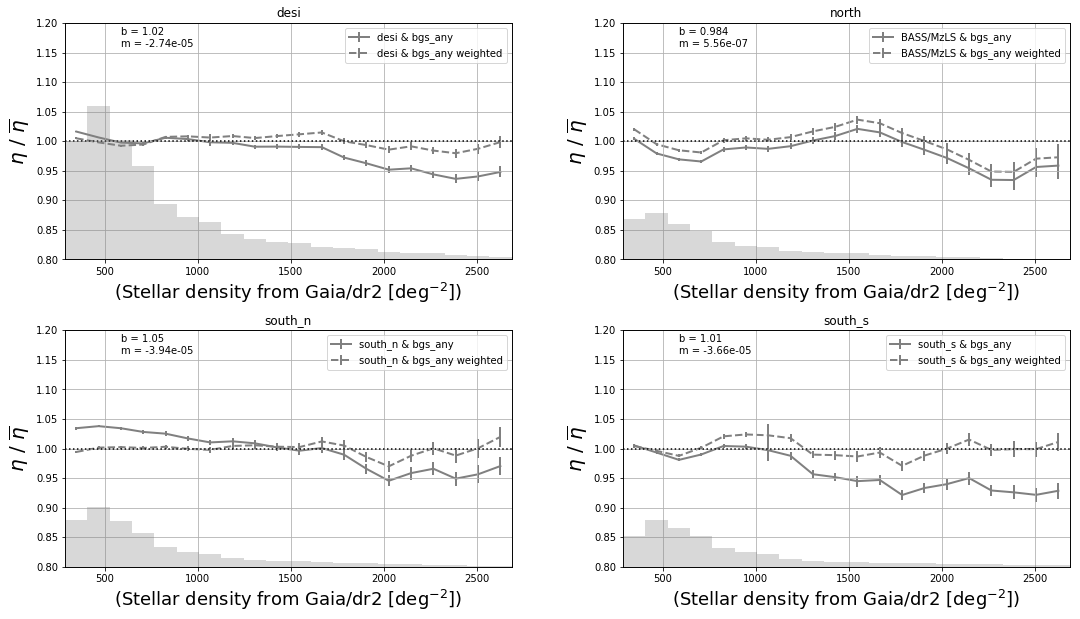

In [29]:
# get b and m coefficients for stellar density weights
fig    = plt.figure(figsize=(18,10))
gs     = gridspec.GridSpec(2,2,hspace=0.30,wspace=0.25)

isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
namesel = 'bgs_any'
syst='stardens'
ws = {}

for num, key in enumerate(['desi', 'north', 'south_n', 'south_s']):

#fig    = plt.figure(figsize=(9,5))
#gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    
    b0, m0 = plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=[key], syst=syst, mainreg=isdesi, xlim=None, n=num, nx=20, 
             clip=True, denslims=False, ylab=True, weights=True, fig=fig, gs=gs, label=True, title=key)
    
    print(key, b0, m0)
    ws[key] = 1./((m0)*hpdict['stardens'] + b0)

fig.savefig('syst_w_weights_%s_%s_%s_%s.png' %(syst, dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


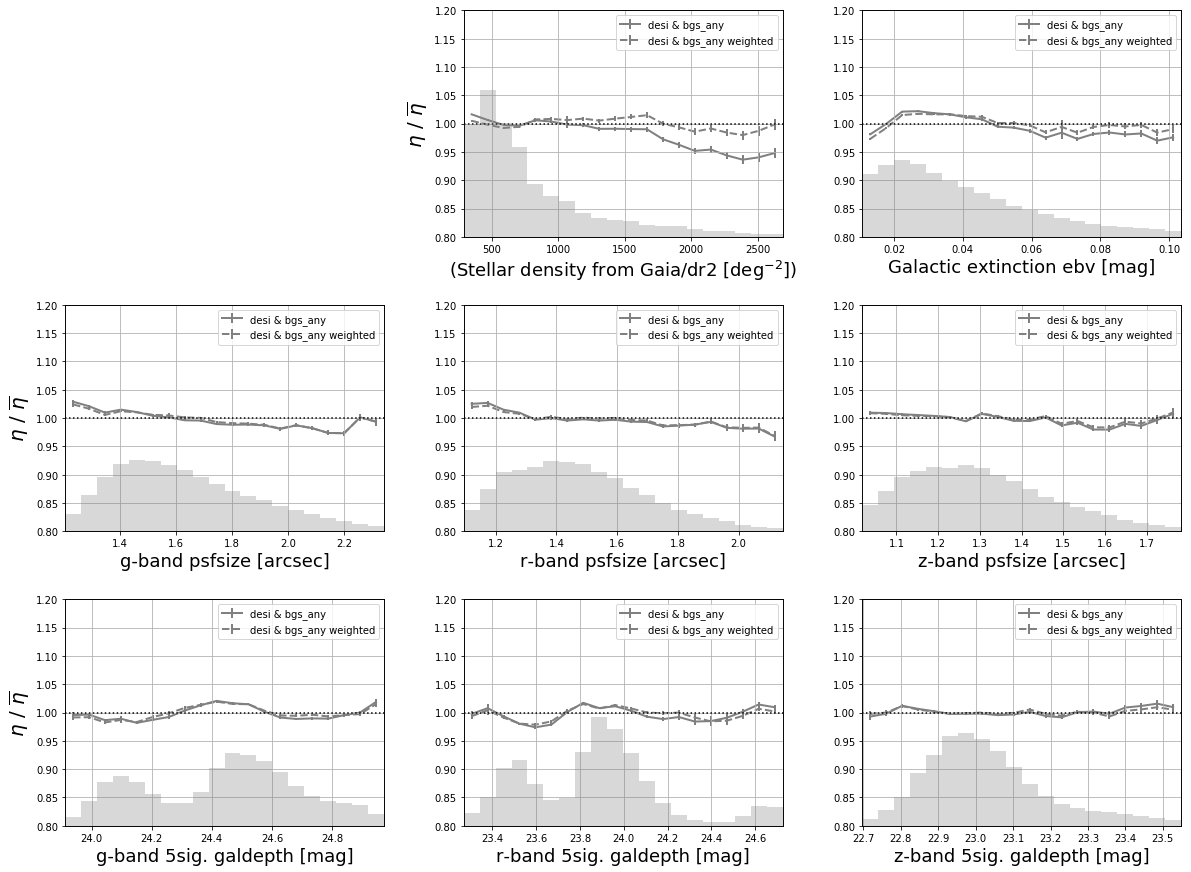

In [32]:
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']

fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
#ws = ws['desi']
namesel = 'bgs_any'
    
for i in range(9):
    
    if i == 0: continue
    if (i%3==0) or (i==1): ylab=True
    else: ylab = False
        
    plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=[reg], syst=systs[i-1], mainreg=isdesi, xlim=None, n=i, nx=20, 
             clip=True, denslims=False, ylab=ylab, weights=True, fig=fig, gs=gs, label=True, ws=ws['desi'])
    
fig.savefig('syst_w_weights_%s_%s_%s.png' %(dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


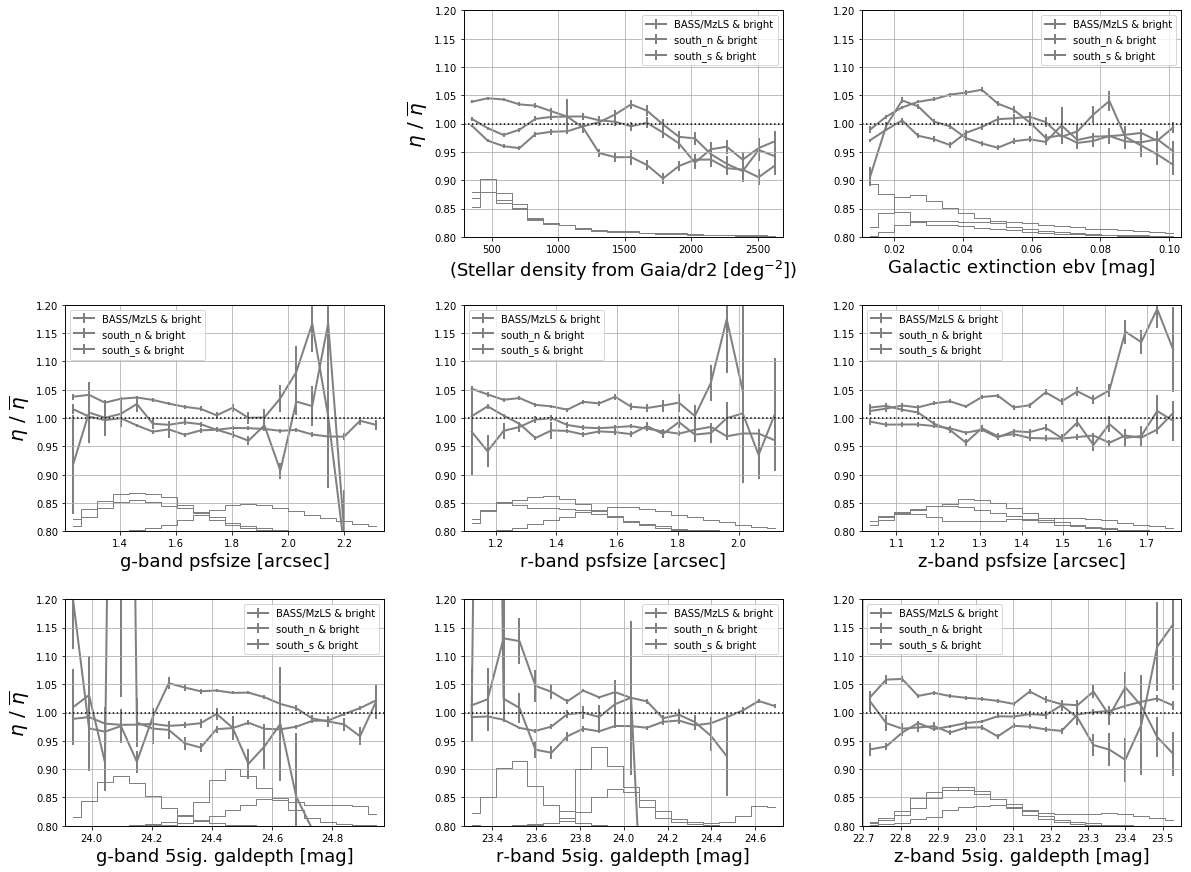

In [53]:
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']

fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
#ws = ws['desi']
namesel = 'bright'
    
for i in range(9):
    
    if i == 0: continue
    if (i%3==0) or (i==1): ylab=True
    else: ylab = False
        
    plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=['north', 'south_n', 'south_s'], syst=systs[i-1], mainreg=isdesi, xlim=None, n=i, nx=20, 
             clip=True, denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=True, ws=None)
    
fig.savefig('syst_w_weights_%s_%s_%s.png' %(dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


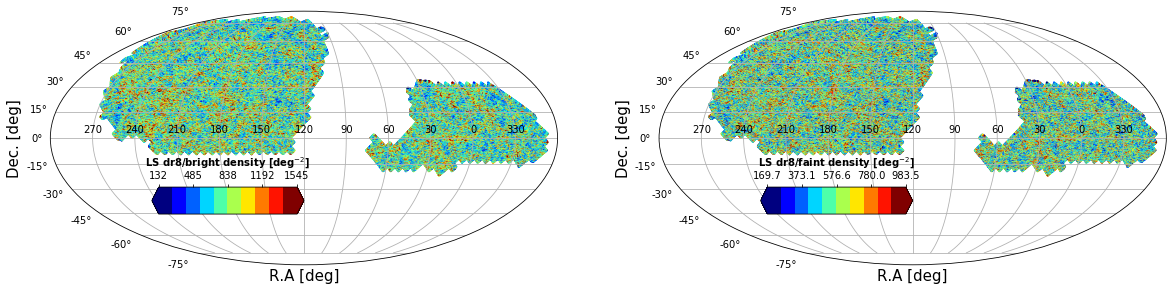

In [34]:
#
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

if reg == 'desi': reg_ = 'all'
else: reg_ = reg
    
mollweide(hpdict=hpdict, namesel='bright', reg=reg_, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict, namesel='faint', reg=reg_, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)

fig.savefig('skymap_dens_%s_%s.png' %(dr, reg), bbox_inches = 'tight', pad_inches = 0)


In [42]:
# match associated target density for each object
import pandas as pd

%time s = pd.Series(extra['hppix'])
%time d = s.groupby(s).groups

DENS = np.zeros_like(cat['RA'])
WS_desi = DENS.copy()
WS_north = DENS.copy()
WS_south_n = DENS.copy()
WS_south_s = DENS.copy()

STARDEN = np.zeros_like(cat['RA'])
hpdens = (hpdict['south_nbgs_any'] + hpdict['north_nbgs_any'] ) / (pixarea * hpdict['bgsfracarea'])
print(len(hpdens), len(WS_desi))
#
for npixid, catids in zip(d.keys(), d.values()):
    DENS[catids] = hpdens[npixid]
    STARDEN[catids] = hpdict['stardens'][npixid]
    WS_desi[catids] = ws['desi'][npixid]
    WS_north[catids] = ws['north'][npixid]
    WS_south_n[catids] = ws['south_n'][npixid]
    WS_south_s[catids] = ws['south_s'][npixid]
    

CPU times: user 55 µs, sys: 16 ms, total: 16.1 ms
Wall time: 16.1 ms
CPU times: user 24.5 s, sys: 2.06 s, total: 26.5 s
Wall time: 26.4 s
786432 26695738


In [43]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)

In [44]:
from astropy.table import Table

tab = Table()

for col in cat.dtype.names:
    tab[col] = cat[col]
    
for col in ['b','des','decals','north','desi','south']:
    tab[col] = extra[col]
    
tab['DENS'] = DENS
tab['WS_desi'] = WS_desi
tab['WS_north'] = WS_north
tab['WS_south_n'] = WS_south_n
tab['WS_south_s'] = WS_south_s
tab['STARDEN'] = STARDEN
tab['bgs'] = bgs_any
tab['bgs_faint'] = bgs_f
tab['bgs_bright'] = bgs_b

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.1'
np.save(dest, tab)

In [45]:
#give the right permissions
!chgrp -R desi /global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.1.npy
!chmod -R g+rX /global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_3.1.npy

c_ran = SkyCoord(randoms['RA']*units.degree,randoms['DEC']*units.degree, frame='icrs')
galb_ran = c_ran.galactic.b.value # galb coordinate
print('GAL b DONE...')

In [46]:
# match associated target density for each object
import pandas as pd

s = pd.Series(ran_ex['hppix'])
d = s.groupby(s).groups

STARDEN_ran = np.zeros_like(randoms['RA'])

#
for npixid, catids in zip(d.keys(), d.values()):
    STARDEN_ran[catids] = hpdict['stardens'][npixid]


In [17]:
#
tabran = Table()

mask = (rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])

tabran['RA'], tabran['DEC'] = randoms['RA'][mask], randoms['DEC'][mask]
tabran['MASKBITS'] = randoms['MASKBITS'][mask]

for col in ['b','des','decals','north','desi','south']:
    tabran[col] = ran_ex[col][mask]
    
tabran['STARDEN'] = STARDEN_ran[mask]
    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/randoms_dr8_N3_pauline_3.0'
np.save(dest, tabran)

## stardens catalogue
GAIA objects that compose the stellar density systematic

        # ADM restrict to subset of point sources.
        ra, dec = gobjs["RA"], gobjs["DEC"]
        gmag = gobjs["PHOT_G_MEAN_MAG"]
        excess = gobjs["ASTROMETRIC_EXCESS_NOISE"]
        point = (excess == 0.) | (np.log10(excess) < 0.3*gmag-5.3)
        grange = (gmag >= 12) & (gmag < 17)
        w = np.where(point & grange)

In [48]:
maskbitsourcesfile = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy'
hppixmasksourcesfile = '/global/cscratch1/sd/qmxp55/BS_mask/hppix_dr8_masksources.npy'

maskbitsources = np.load(maskbitsourcesfile)
hppixmasksources = np.load(hppixmasksourcesfile)

In [55]:
def getStarDenSources(df):
    
    #GAIA objects only
    keep = np.ones_like(df['RA'], dtype=bool)
    
    keep &= df['REF_CAT'] == b'G2'
    keep &= (df['G'] >= 12) & (df['G'] < 17)
    point = (df['AEN'] == 0.) | (np.log10(df['AEN']) < 0.3*df['G']-5.3)
    mask = (point) & (keep)
    print(np.sum(mask))
    #
    return mask

In [56]:
stardens = getStarDenSources(maskbitsources)

18709321


In [62]:
maskbitsourcesinregfile = '/global/cscratch1/sd/qmxp55/BS_mask/inREGIONS_dr8_masksources.npy'
maskbitsourcesinreg = np.load(maskbitsourcesinregfile)

In [66]:
#
tabstarden = Table()

for col in ['RA', 'DEC', 'G']:
    tabstarden[col] = maskbitsources[col][stardens]
    
for col in ['des', 'decals', 'north', 'desi']:
    tabstarden[col] = maskbitsourcesinreg[col][stardens]
tabstarden['south'] = (maskbitsourcesinreg['des'][stardens]) | (maskbitsourcesinreg['decals'][stardens])

    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/GAIA_12_17_pointsources'
np.save(dest, tabstarden)

In [72]:
set(maskbitsources['REF_CAT'][stardens])

{b'G2'}

# Sanity checks with some skyplots...

Text(0, 0.5, 'Dec.')

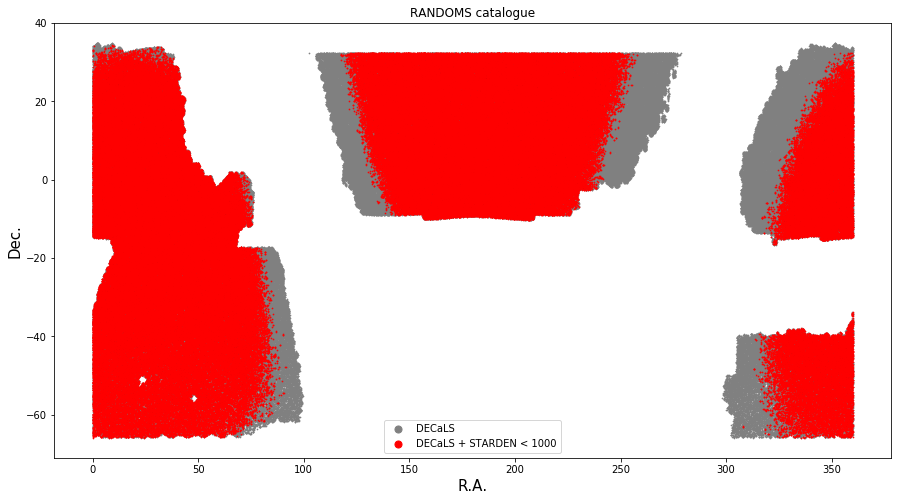

In [24]:
plt.figure(figsize=(15,8))

mask2 = tabran['STARDEN'] < 1000
maskn = (tabran['north']) & (tabran['desi'])
masks_n = (tabran['south']) & (tabran['desi']) & (tabran['b'] > 0)
masks_s = (tabran['south']) & (tabran['desi']) & (tabran['b'] < 0)
N = 500

#plt.scatter(tabran['RA'][::N], tabran['DEC'][::N], s=0.5, c='gray', label='all')
#plt.scatter(tabran['RA'][masks_n][::N], tabran['DEC'][masks_n][::N], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
#plt.scatter(tabran['RA'][masks_s][::N], tabran['DEC'][masks_s][::N], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
#plt.scatter(tabran['RA'][maskn][::N], tabran['DEC'][maskn][::N], s=0.5, c='k', label='BASS/MzLS = desi & north')

#sanity check for STARDEN
plt.scatter(tabran['RA'][(tabran['south'])][::N], tabran['DEC'][(tabran['south'])][::N], s=0.5, c='gray', label='DECaLS')
plt.scatter(tabran['RA'][(tabran['south']) & (mask2)][::N], tabran['DEC'][(tabran['south']) & (mask2)][::N], s=0.5, c='r', label='DECaLS + STARDEN < 1000')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

plt.title('RANDOMS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


Text(0, 0.5, 'Dec.')

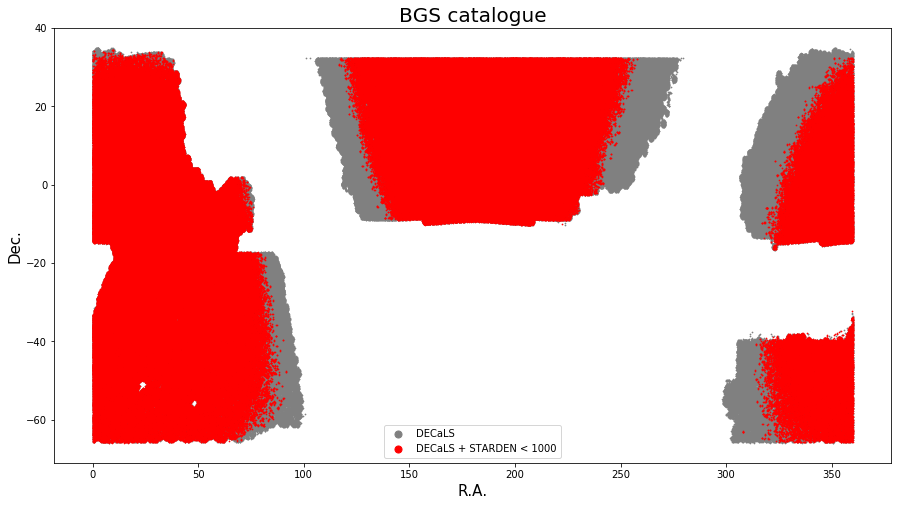

In [47]:
plt.figure(figsize=(15,8))

N = 30
#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
mask2 = tab['STARDEN'] < 1000
maskn = (tab['north']) & (tab['desi'])
masks_n = (tab['south']) & (tab['desi']) & (tab['b'] > 0)
masks_s = (tab['south']) & (tab['desi']) & (tab['b'] < 0)

#plt.scatter(tab['RA'][::N], tab['DEC'][::N], s=0.5, c='gray', label='all')
#plt.scatter(tab['RA'][masks_n][::N], tab['DEC'][masks_n][::N], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
#plt.scatter(tab['RA'][masks_s][::N], tab['DEC'][masks_s][::N], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
#plt.scatter(tab['RA'][maskn][::N], tab['DEC'][maskn][::N], s=0.5, c='k', label='BASS/MzLS = desi & north')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

#sanity check for STARDEN
plt.scatter(tab['RA'][(tab['south'])][::N], tab['DEC'][(tab['south'])][::N], s=0.5, c='gray', label='DECaLS')
plt.scatter(tab['RA'][(tab['south']) & (mask2)][::N], tab['DEC'][(tab['south']) & (mask2)][::N], s=0.5, c='r', label='DECaLS + STARDEN < 1000')


plt.title('BGS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


In [52]:
tab.dtype.names

('TYPE',
 'RA',
 'DEC',
 'GMAG',
 'RMAG',
 'ZMAG',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'RFIBERMAG',
 'REF_CAT',
 'REF_ID',
 'G',
 'AEN',
 'MASKBITS',
 'FLUX_R',
 'BGSBITS',
 'b',
 'des',
 'decals',
 'north',
 'desi',
 'south',
 'DENS',
 'WS_desi',
 'WS_north',
 'WS_south_n',
 'WS_south_s',
 'STARDEN',
 'bgs',
 'bgs_faint',
 'bgs_bright')

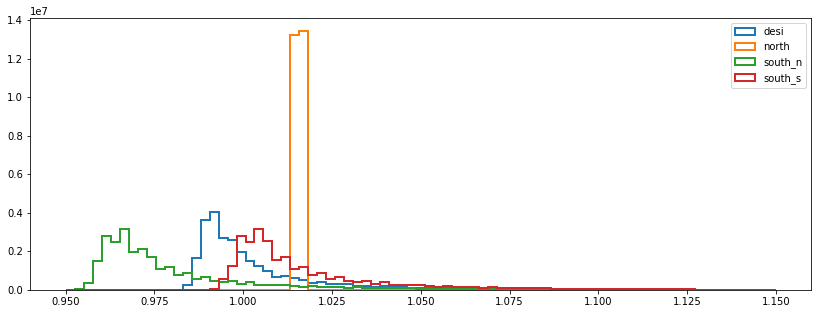

In [51]:
#
plt.figure(figsize=(14, 5))
bins = np.linspace(.95, 1.15, 80)
for i in ['desi', 'north', 'south_n', 'south_s']:
    
    plt.hist(tab['WS_'+i], bins=bins, histtype='step', lw=2, label=i)
    plt.legend()


In [67]:
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/GAIA_12_17_pointsources.npy')

In [68]:
stars.dtype.names

('RA', 'DEC', 'G', 'des', 'decals', 'north', 'desi', 'south')

Text(0, 0.5, 'Dec.')

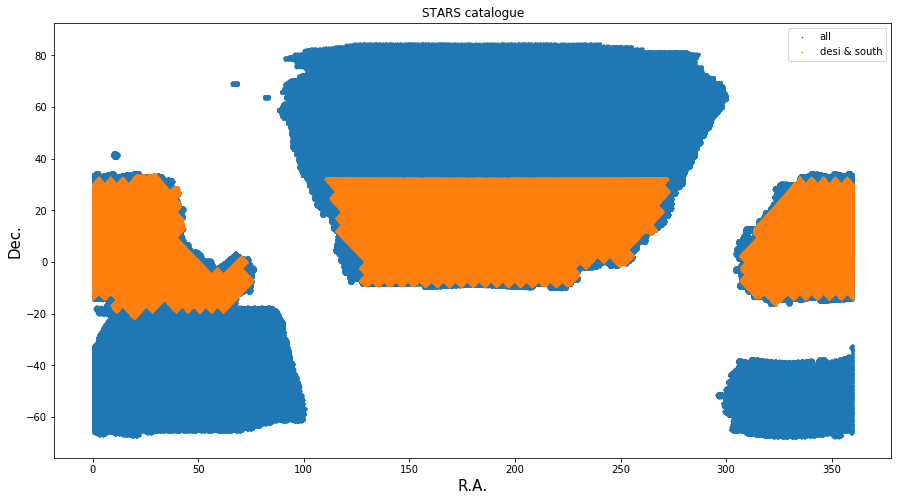

In [69]:
plt.figure(figsize=(15,8))

#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
mask = (stars['south']) & (stars['desi'])
#plt.scatter(tab['RA'][tab['north']][::1000], tab['DEC'][tab['north']][::1000], label='north')
plt.scatter(stars['RA'][::5], stars['DEC'][::5], s=0.5, label='all')
#plt.scatter(stars['RA'][stars['issouth']][::10], stars['DEC'][stars['issouth']][::10], s=0.5, label='south')
plt.scatter(stars['RA'][mask][::5], stars['DEC'][mask][::5], s=0.5, label='desi & south')

plt.title('STARS catalogue')

plt.legend()
plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


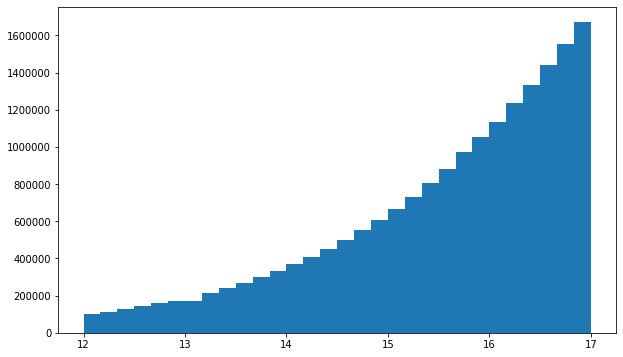

In [70]:
plt.figure(figsize=(10,6))
plt.hist(stars['G'], 30)
plt.show()

### Below code is for desitarget outputs only

In [ ]:
cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                        'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                             'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'MORPHTYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                   'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z']

In [33]:
#
from astropy.table import Table

tab = Table()
for col in cols:
    if (col[:4] == 'FLUX') & (col[:9] != 'FLUX_IVAR'): tab[col[-1:]+'MAG'] = flux_to_mag(cat['FLUX_'+col[-1:]]/cat['MW_TRANSMISSION_'+col[-1:]])
    elif col[:2] == 'MW': continue
    elif col == 'FIBERFLUX_R': tab['RFIBERMAG'] = flux_to_mag(cat[col]/cat['MW_TRANSMISSION_R'])
    elif col == 'GAIA_PHOT_G_MEAN_MAG': tab['G'] = cat[col]
    elif col == 'GAIA_ASTROMETRIC_EXCESS_NOISE': tab['AEN'] = cat[col]
    else: tab[col] = cat[col]
        
for key in catinregs.keys():
    tab[key] = catinregs[key]
    
tab['FLUX_R'] = cat['FLUX_R']
tab['DENS'] = DENS
tab['WS'] = WS
tab['bgs'] = bgs
tab['bgs_faint'] = bgsf
tab['bgs_bright'] = bgsb
tab['galb'] = galb

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_2.0'
np.save(dest, tab)
